# DD2421 Machine Learning – Lab 2: Support Vector Machines

This notebook implements the full assignment: building a Support Vector Machine (SVM) classifier using the dual formulation, experimenting with linear, polynomial, and RBF kernels, and exploring the effects of the slack parameter `C`.

> **How to use**
1. Run the **Setup** cell first.
2. Skim the **Theory recap** if you like.
3. Execute cells in **Implementation**, then try the **Experiments** sections.
4. Use the helper widgets/functions at the bottom to play with parameters interactively.

*Created for the DD2421 Lab 2 assignment.*

### Theory recap (brief)

Given training points $\{(\mathbf{x}_i, t_i)\}_{i=1}^N$ with targets $t_i \in \{-1,+1\}$ and kernel $K(\mathbf{x},\mathbf{y}) = \phi(\mathbf{x})^\top\phi(\mathbf{y})$, the **dual** problem with slack is:
\begin{align}
\min_{\boldsymbol{\alpha}}\; &\; \frac{1}{2}\sum_i\sum_j \alpha_i \alpha_j t_i t_j K(\mathbf{x}_i,\mathbf{x}_j) - \sum_i \alpha_i\\
\text{s.t. } &\; 0 \le \alpha_i \le C,\quad \sum_i \alpha_i t_i = 0.
\end{align}
The indicator for a new point $\mathbf{s}$ is
$$\text{ind}(\mathbf{s}) = \sum_i \alpha_i t_i K(\mathbf{s},\mathbf{x}_i) - b,$$
with $b$ computed from any **support vector** (SV) that satisfies $0<\alpha_i<C$ as
$$ b = \sum_j \alpha_j t_j K(\mathbf{x}_i,\mathbf{x}_j) - t_i. $$


In [34]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# plotting defaults: single-plot charts; users can adjust styles if they wish
plt.rcParams['figure.figsize'] = (6, 5)

# Reproducibility
np.random.seed(100)


### Kernels

In [35]:
class Kernels:
    @staticmethod
    def linear(x, y):
        return np.dot(x, y)

    @staticmethod
    def polynomial(x, y, p=2, c=1.0):
        return (np.dot(x, y) + c)**p

    @staticmethod
    def rbf(x, y, sigma=1.0):
        diff = x - y
        return np.exp(-(np.dot(diff, diff)) / (2.0*sigma*sigma))


### Data generation

In [36]:
def make_toy_data(seed=100,
                  A1_center=(1.5,0.5), A2_center=(-1.5,0.5), B_center=(0.0,-0.5),
                  A1_n=10, A2_n=10, B_n=20, sigma=0.2):
    """Generate 2D toy data for two classes."""
    rng = np.random.default_rng(seed)
    classA = np.concatenate([
        rng.normal(0, 1, (A1_n, 2))*sigma + np.array(A1_center),
        rng.normal(0, 1, (A2_n, 2))*sigma + np.array(A2_center)
    ])
    classB = rng.normal(0, 1, (B_n, 2))*sigma + np.array(B_center)
    inputs = np.concatenate([classA, classB])
    targets = np.concatenate([np.ones(classA.shape[0]), -np.ones(classB.shape[0])])
    # shuffle
    idx = np.arange(inputs.shape[0])
    rng.shuffle(idx)
    return classA, classB, inputs[idx], targets[idx]

def plot_data(classA, classB, support_vectors=None, ax=None):
    ax = ax or plt.gca()
    ax.plot([p[0] for p in classA], [p[1] for p in classA], '.', label='Class +1')
    ax.plot([p[0] for p in classB], [p[1] for p in classB], '.', label='Class -1')
    if support_vectors is not None and len(support_vectors) > 0:
        sv = np.array(support_vectors)
        ax.plot(sv[:,0], sv[:,1], 'x', markersize=9, label='Support vectors')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.set_title('Toy data')

### Decision boundary plotting

In [37]:
def plot_decision_boundary(model, classA, classB, xrange=(-5,5), yrange=(-4,4), grid_n=100, show_labels=False):
    xgrid = np.linspace(xrange[0], xrange[1], grid_n)
    ygrid = np.linspace(yrange[0], yrange[1], grid_n)
    grid = np.zeros((grid_n, grid_n))
    for i, y in enumerate(ygrid):
        XY = np.column_stack([xgrid, np.full_like(xgrid, y)])
        grid[i, :] = model.indicator(XY)

    fig, ax = plt.subplots()
    CS = ax.contour(xgrid, ygrid, grid, levels=[-1.0, 0.0, 1.0])
    if show_labels:
        ax.clabel(CS, inline=True, fontsize=8)  # set show_labels=True to draw text

    # draw points & SVs on the SAME axes
    plot_data(classA, classB, model.support_X, ax=ax)
    ax.set_title('Decision boundary and margins')
    plt.show()

### SVM (dual, with slack) implementation

In [38]:
class DualSVM:
    def __init__(self, kernel, C=None, kernel_params=None):
        self.kernel = kernel
        self.C = C
        self.kernel_params = kernel_params or {}
        self.alpha = None
        self.support_idx = None
        self.support_X = None
        self.support_t = None
        self.b = None
        self.P = None  # Precomputed matrix P_ij = t_i t_j K(x_i, x_j)

    def _K(self, a, b):
        return self.kernel(a, b, **self.kernel_params) if self.kernel_params else self.kernel(a, b)

    def fit(self, X, t, tol=1e-5):
        N = X.shape[0]
        # Precompute P
        P = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                P[i, j] = t[i]*t[j]*self._K(X[i], X[j])
        self.P = P

        def objective(alpha):
            a = np.asarray(alpha)
            return 0.5*np.dot(a, P @ a) - np.sum(a)

        def zerofun(alpha):
            return np.dot(alpha, t)

        start = np.zeros(N)
        bounds = [(0, self.C if self.C is not None else None) for _ in range(N)]
        constraints = {'type': 'eq', 'fun': zerofun}

        res = minimize(objective, start, bounds=bounds, constraints=constraints)
        if not res.success:
            raise RuntimeError(f"Optimizer failed: {res.message}")

        alpha = res.x
        # support vectors: alpha > tol
        sv_mask = alpha > tol
        # For computing b we want 0 < alpha < C (if C is used)
        if self.C is not None:
            margin_mask = (alpha > tol) & (alpha < (self.C - tol))
        else:
            margin_mask = (alpha > tol)

        self.alpha = alpha[sv_mask]
        self.support_idx = np.where(sv_mask)[0]
        self.support_X = X[sv_mask]
        self.support_t = t[sv_mask]

        # Compute b using any margin SV; if none, fall back to mean over SVs
        if np.any(margin_mask):
            idxs = np.where(margin_mask)[0]
        else:
            idxs = self.support_idx
        if len(idxs) == 0:
            raise RuntimeError("No support vectors found; try different parameters or data.")

        b_vals = []
        for s in idxs:
            s_val = 0.0
            for ai, ti, xi in zip(self.alpha, self.support_t, self.support_X):
                s_val += ai * ti * self._K(X[s], xi)
            b_vals.append(s_val - t[s])
        self.b = np.mean(b_vals)
        return self

    def indicator(self, S):
        """Return indicator values for S (array of shape (M,2) or (2,))."""
        S = np.atleast_2d(S)
        vals = []
        for s in S:
            acc = 0.0
            for ai, ti, xi in zip(self.alpha, self.support_t, self.support_X):
                acc += ai * ti * self._K(s, xi)
            vals.append(acc - self.b)
        return np.array(vals)

    def predict(self, S):
        return np.sign(self.indicator(S))


### Experiment 1: Linear kernel

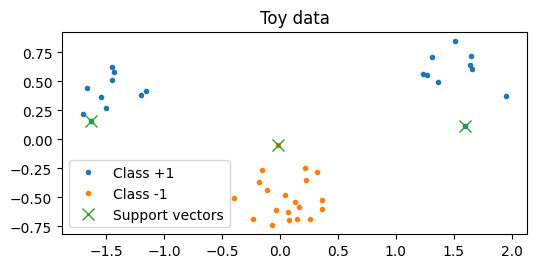

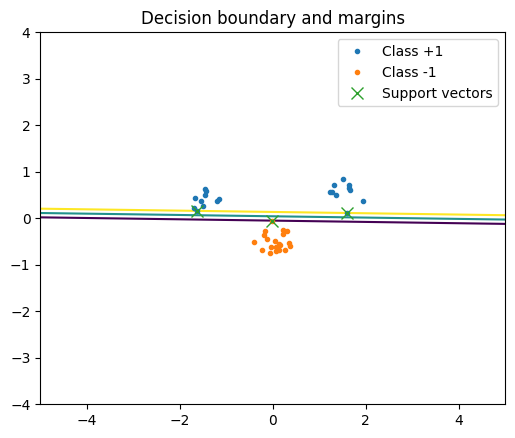

In [39]:
classA, classB, X, t = make_toy_data()
model_lin = DualSVM(Kernels.linear, C=None)
model_lin.fit(X, t)
plot_data(classA, classB, model_lin.support_X)
plot_decision_boundary(model_lin, classA, classB)


### Experiment 2: Polynomial kernel

Polynomial kernel p=2


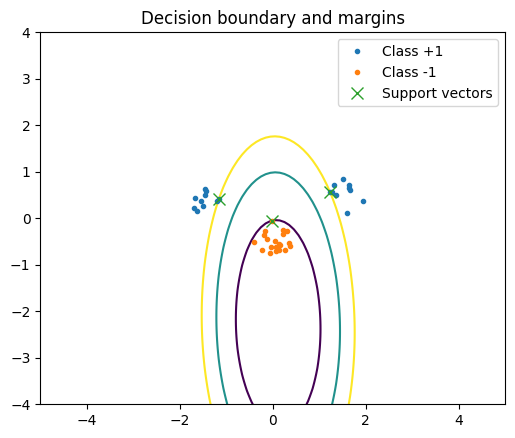

Polynomial kernel p=3


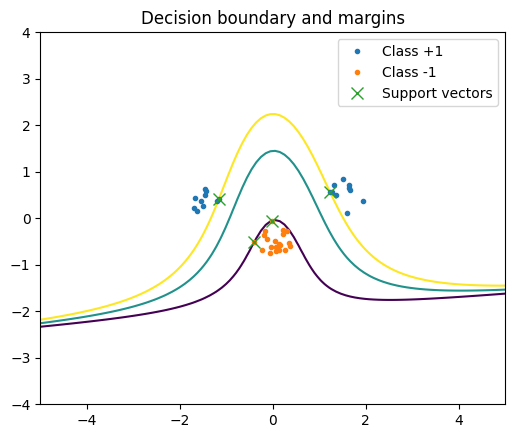

In [40]:
for p in [2, 3]:
    print(f'Polynomial kernel p={p}')
    model_poly = DualSVM(Kernels.polynomial, C=10.0, kernel_params={'p': p, 'c':1.0})
    model_poly.fit(X, t)
    plot_decision_boundary(model_poly, classA, classB)


### Experiment 3: RBF kernel

RBF kernel sigma=0.2


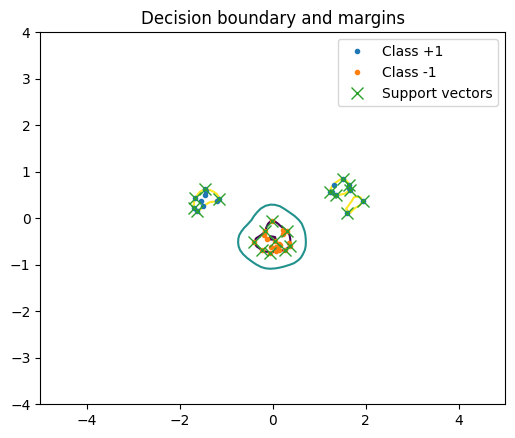

RBF kernel sigma=0.5


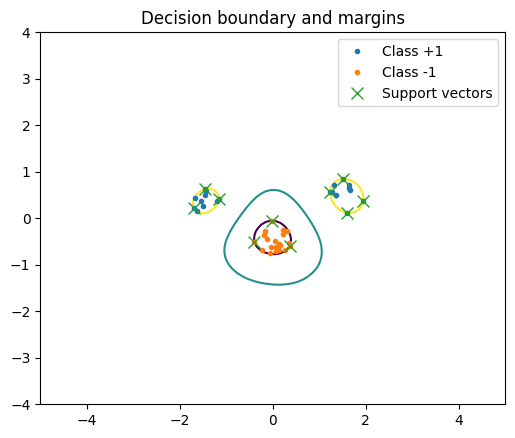

RBF kernel sigma=1.0


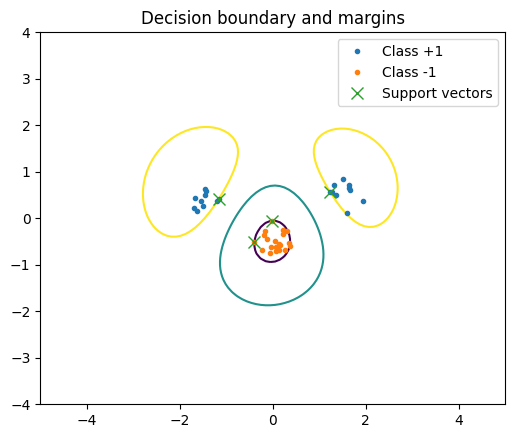

In [41]:
for sigma in [0.2, 0.5, 1.0]:
    print(f'RBF kernel sigma={sigma}')
    model_rbf = DualSVM(Kernels.rbf, C=10.0, kernel_params={'sigma': sigma})
    model_rbf.fit(X, t)
    plot_decision_boundary(model_rbf, classA, classB)


### Experiment 4: Effect of slack parameter $C$

RBF kernel with sigma=0.5, C=0.1


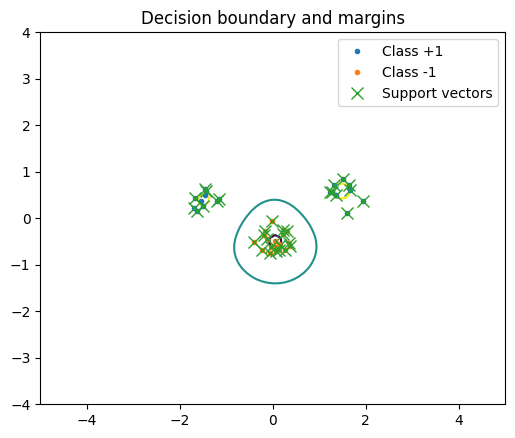

RBF kernel with sigma=0.5, C=1.0


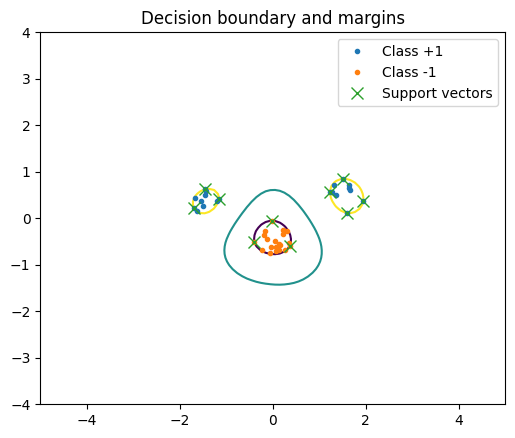

RBF kernel with sigma=0.5, C=10.0


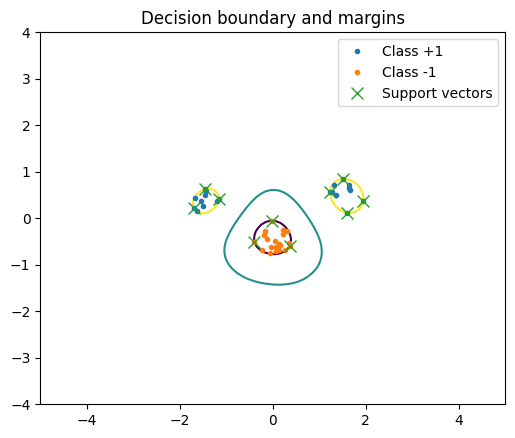

RBF kernel with sigma=0.5, C=100.0


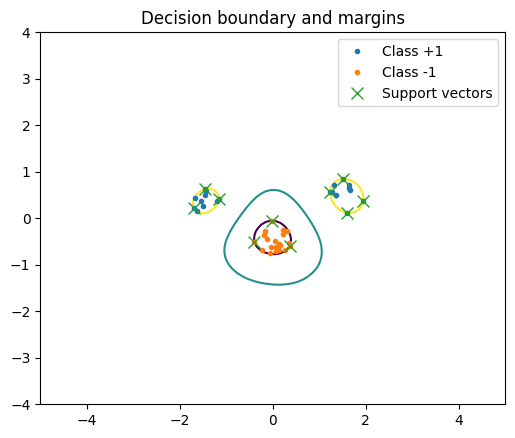

In [45]:
sig = 0.5
for C in [0.1, 1.0, 10.0, 100.0]:
    print(f'RBF kernel with sigma={sig}, C={C}')
    model = DualSVM(Kernels.rbf, C=C, kernel_params={'sigma': sig})
    model.fit(X, t)
    plot_decision_boundary(model, classA, classB)


### Notes & prompts for your report
- **Kernels & parameters**: Increasing polynomial degree `p` or decreasing RBF `sigma` yields more flexible (wiggly) boundaries (higher variance, lower bias). Opposite settings smooth the boundary (higher bias, lower variance).
- **Slack `C`**: Larger `C` penalizes violations more (narrower margins, fewer training errors, risk of overfit). Smaller `C` allows more violations (wider margins, potentially better generalization on noisy data).
- **When to add slack vs. change kernel?** If noise/outliers dominate, prefer **more slack** (smaller `C`). If classes are not linearly separable but noise is modest, prefer a **more expressive kernel**.


### Helper: quick-train convenience function

In [44]:
def train_and_plot(kernel_name='rbf', C=10.0, p=2, c=1.0, sigma=0.5,
                   A1_center=(1.5,0.5), A2_center=(-1.5,0.5), B_center=(0.0,-0.5),
                   sigma_data=0.2, seed=100):
    classA, classB, X, t = make_toy_data(seed=seed,
                                         A1_center=A1_center,
                                         A2_center=A2_center,
                                         B_center=B_center,
                                         sigma=sigma_data)
    if kernel_name=='linear':
        kfun, params = Kernels.linear, {}
        cparam = None if C is None else C
    elif kernel_name=='poly':
        kfun, params = Kernels.polynomial, {'p': p, 'c': c}
        cparam = C
    elif kernel_name=='rbf':
        kfun, params = Kernels.rbf, {'sigma': sigma}
        cparam = C
    else:
        raise ValueError('kernel_name must be one of: linear, poly, rbf')
    model = DualSVM(kfun, C=cparam, kernel_params=params)
    model.fit(X, t)
    plot_decision_boundary(model, classA, classB)
    return model, (classA, classB, X, t)


### Tougher dataset for linear

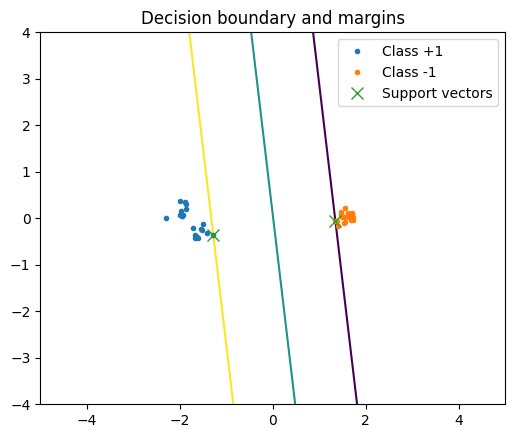

[Linear EASY] train acc=1.000, SVs=2


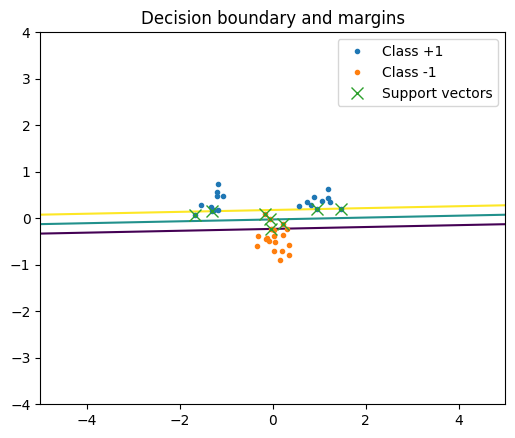

[Linear HARD] train acc=0.950, SVs=8


In [50]:
# EASY for LINEAR: both +1 blobs on the left, -1 blob on the right (linearly separable)
model_lin_easy, data = train_and_plot(
    kernel_name='linear', C=10.0,
    A1_center=(-2.0,  0.2), A2_center=(-1.6, -0.3), B_center=(1.6, 0.0),
    sigma_data=0.15, seed=42
)
X, t = data[2], data[3]
acc = (model_lin_easy.predict(X) == t).mean()
print(f"[Linear EASY] train acc={acc:.3f}, SVs={len(model_lin_easy.alpha)}")


# HARD for LINEAR: +1 blobs on the sides, -1 in the middle (nonlinearly separable)
model_lin_hard, data = train_and_plot(
    kernel_name='linear', C=10.0,
    A1_center=(-1.2, 0.4), A2_center=(1.2, 0.4), B_center=(0.0, -0.4),
    sigma_data=0.25, seed=7
)
X, t = data[2], data[3]
acc = (model_lin_hard.predict(X) == t).mean()
print(f"[Linear HARD] train acc={acc:.3f}, SVs={len(model_lin_hard.alpha)}")


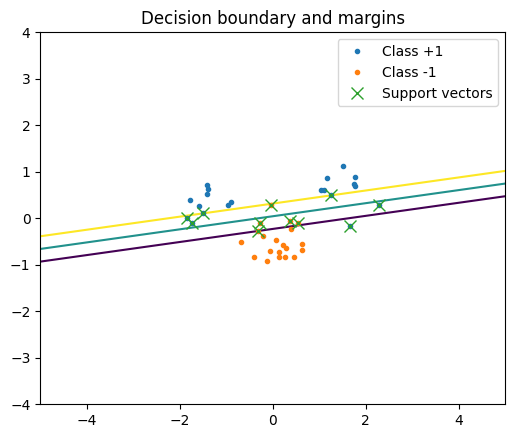

In [46]:
model_lin, _  = train_and_plot(kernel_name='linear', C=10.0, sigma=0.5,
                               sigma_data=0.35)  # more noise → harder

### Tougher dataset for polynomial

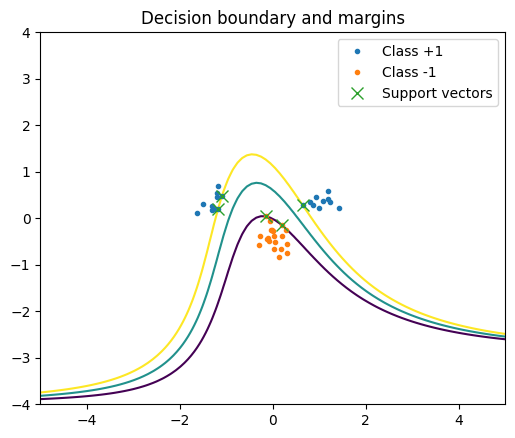

[Poly EASY p=3] train acc=1.000, SVs=5


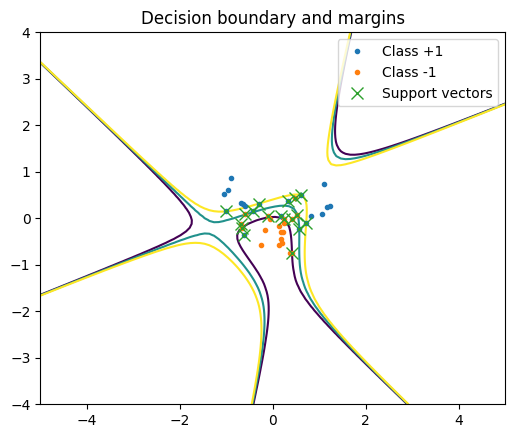

[Poly HARD p=3] train acc=0.875, SVs=18


In [51]:
# EASY for POLY: the "two +1 on sides, -1 in center" is easy for a cubic polynomial
model_poly_easy, data = train_and_plot(
    kernel_name='poly', C=10.0, p=3, c=1.0,
    A1_center=(-1.2, 0.4), A2_center=(1.2, 0.4), B_center=(0.0, -0.4),
    sigma_data=0.22, seed=7
)
X, t = data[2], data[3]
acc = (model_poly_easy.predict(X) == t).mean()
print(f"[Poly EASY p=3] train acc={acc:.3f}, SVs={len(model_poly_easy.alpha)}")


# HARD for POLY: bring clusters closer and add noise; still usually better than linear
model_poly_hard, data = train_and_plot(
    kernel_name='poly', C=10.0, p=3, c=1.0,
    A1_center=(-0.9, 0.35), A2_center=(0.9, 0.35), B_center=(0.0, -0.25),
    sigma_data=0.38, seed=11
)
X, t = data[2], data[3]
acc = (model_poly_hard.predict(X) == t).mean()
print(f"[Poly HARD p=3] train acc={acc:.3f}, SVs={len(model_poly_hard.alpha)}")


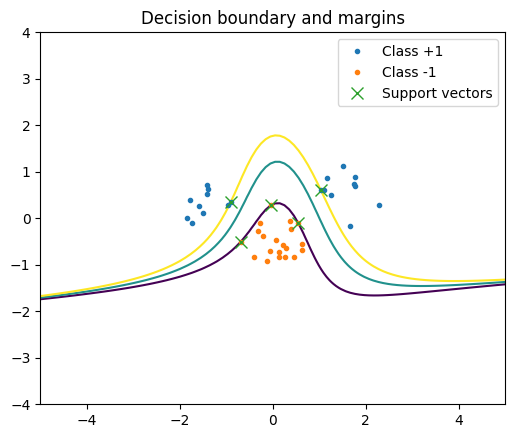

In [47]:
model_poly, _ = train_and_plot(kernel_name='poly',   C=10.0, p=3, c=1.0,
                               sigma_data=0.35)

### Tougher dataset for RBF

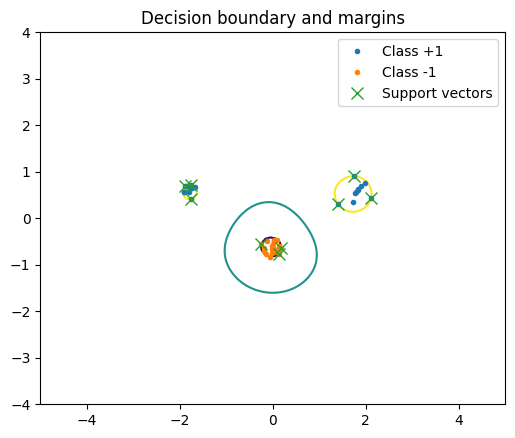

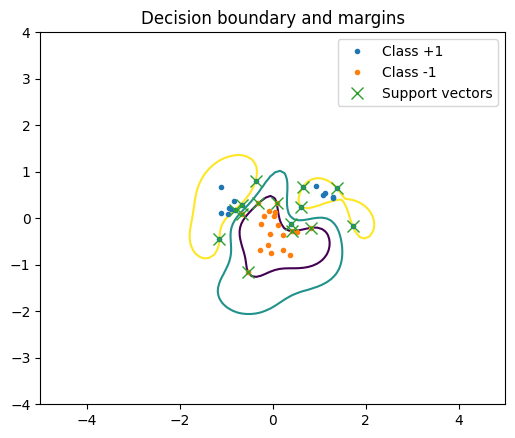

(<__main__.DualSVM at 0x2027f8cb3e0>,
 (array([[-0.93383132,  0.21703805],
         [-1.14457224, -0.45451358],
         [-0.37010242,  0.80045806],
         [-1.11389799,  0.67083231],
         [-0.90157627,  0.20616201],
         [-0.65785139,  0.29130521],
         [-1.11508837,  0.12274864],
         [-0.84076468,  0.36528068],
         [-0.80914895,  0.18748501],
         [-0.95561025,  0.08770408],
         [ 1.29451274,  0.46581228],
         [ 1.11569985,  0.54367637],
         [ 0.64623487,  0.67411335],
         [ 1.71984599, -0.17345488],
         [ 0.39470599, -0.12669099],
         [ 1.29451061,  0.44505048],
         [ 1.37741985,  0.65285081],
         [ 1.07370013,  0.49941335],
         [ 0.94058383,  0.70396107],
         [ 0.60459941,  0.25234941]]),
  array([[ 0.0850286 ,  0.3304973 ],
         [-0.26756244, -0.67767116],
         [-0.19715052,  0.03924527],
         [-0.08225193,  0.16352146],
         [-0.65538533,  0.0949831 ],
         [ 0.36220318, -0.79653299]

In [49]:
# EASY: far apart, tight clusters
train_and_plot(kernel_name='rbf', C=10.0, sigma=0.6,
               A1_center=(-1.8, 0.6), A2_center=(1.8, 0.6), B_center=(0.0, -0.6),
               sigma_data=0.15, seed=1)

# HARD: bring them closer + add noise
train_and_plot(kernel_name='rbf', C=10.0, sigma=0.5,
               A1_center=(-1.0, 0.4), A2_center=(1.0, 0.4), B_center=(0.0, -0.3),
               sigma_data=0.35, seed=2)


In [ ]:
model_rbf, _  = train_and_plot(kernel_name='rbf',    C=10.0, sigma=0.4,
                               sigma_data=0.35)

### Assignment 3: kernel parameters bias-variance trade-off

Polynomial and degree p

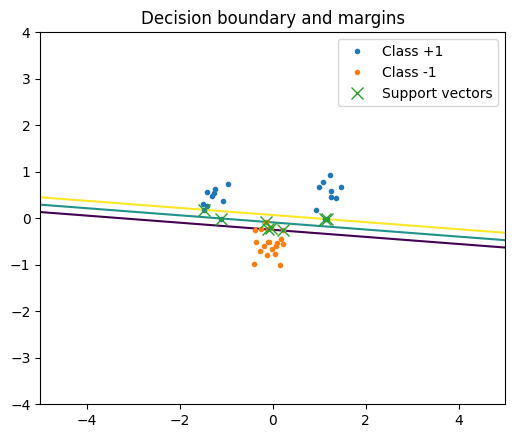

Poly p=1: train_acc=0.950, test_acc=1.000, SVs=8


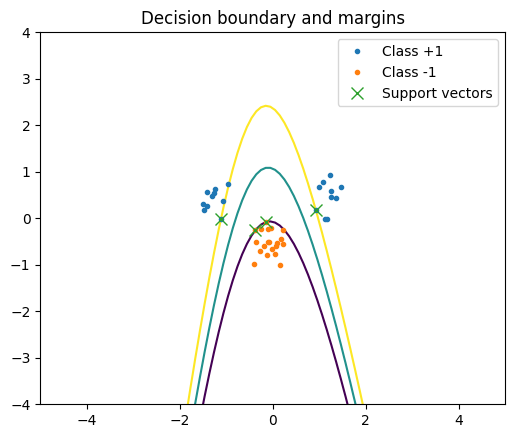

Poly p=2: train_acc=1.000, test_acc=1.000, SVs=4


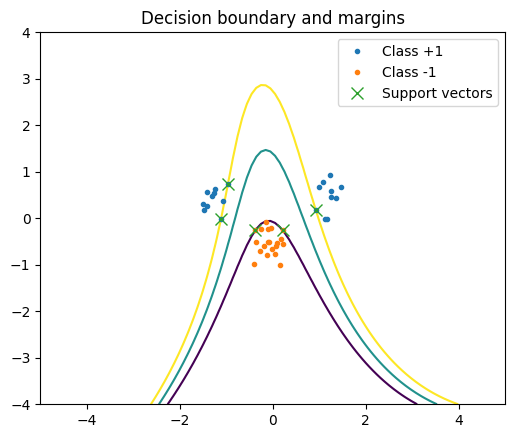

Poly p=3: train_acc=1.000, test_acc=1.000, SVs=5


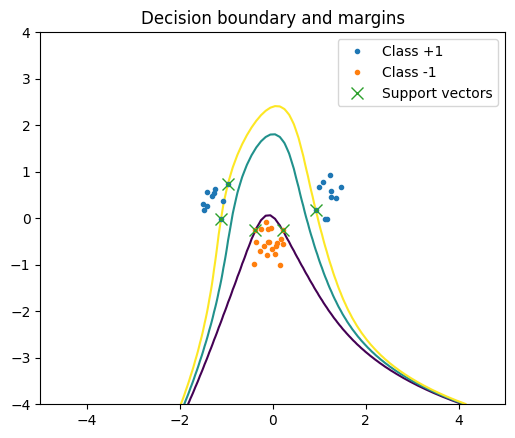

Poly p=5: train_acc=1.000, test_acc=0.975, SVs=5


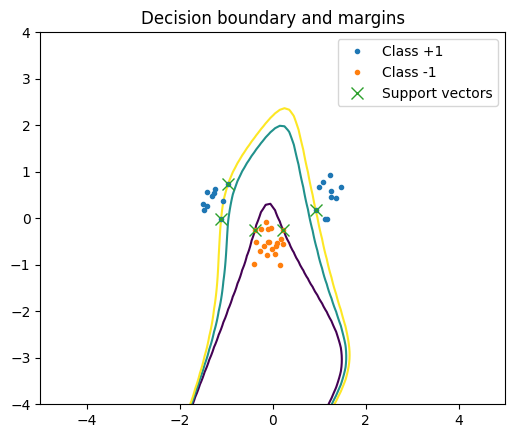

Poly p=8: train_acc=1.000, test_acc=0.925, SVs=5


In [52]:
# Train/test split on the *same* distribution
classA, classB, X, t = make_toy_data(seed=10, sigma=0.28,
                                     A1_center=(-1.2,0.5), A2_center=(1.2,0.5), B_center=(0.0,-0.4))
# make a separate test set with a different seed
_, _, X_te, t_te = make_toy_data(seed=999, sigma=0.28,
                                 A1_center=(-1.2,0.5), A2_center=(1.2,0.5), B_center=(0.0,-0.4))

for p in [1, 2, 3, 5, 8]:
    model = DualSVM(Kernels.polynomial, C=10.0, kernel_params={'p': p, 'c': 1.0})
    model.fit(X, t)
    # Plot
    plot_decision_boundary(model, classA, classB)
    # Metrics
    train_acc = (model.predict(X) == t).mean()
    test_acc  = (model.predict(X_te) == t_te).mean()
    print(f"Poly p={p}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}, SVs={len(model.alpha)}")


RBF and sigma

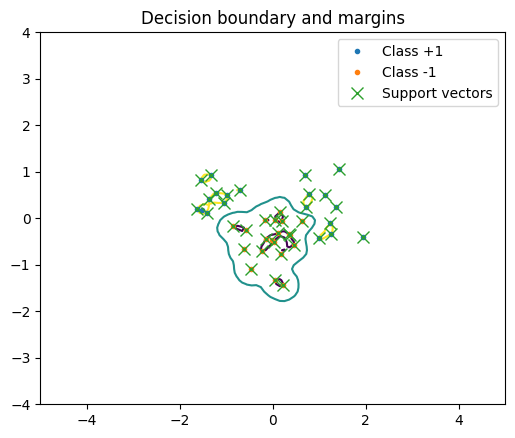

RBF σ=0.15: train_acc=1.000, test_acc=0.975, SVs=38


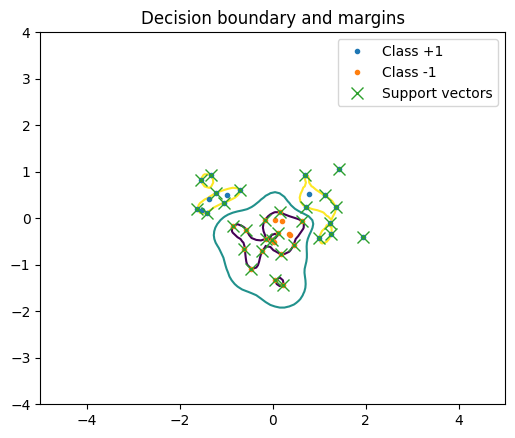

RBF σ=0.25: train_acc=1.000, test_acc=0.975, SVs=31


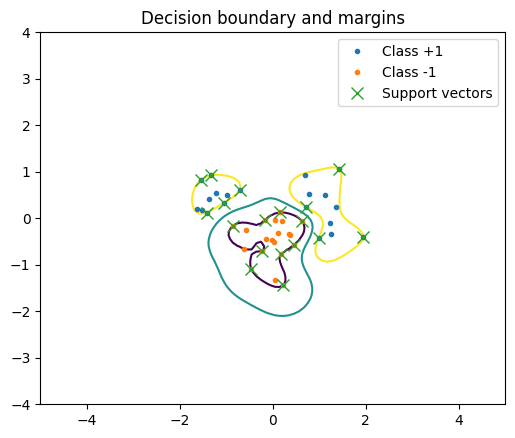

RBF σ=0.4: train_acc=1.000, test_acc=0.975, SVs=18


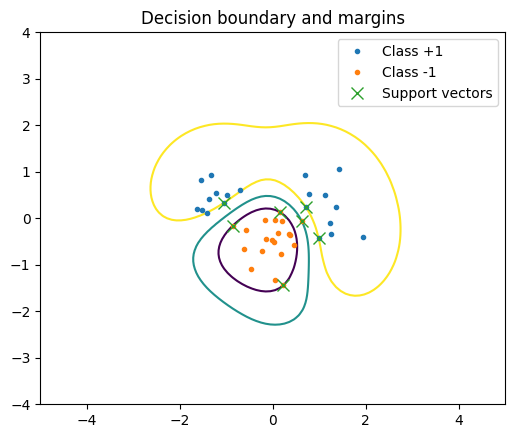

RBF σ=0.8: train_acc=0.975, test_acc=0.950, SVs=7


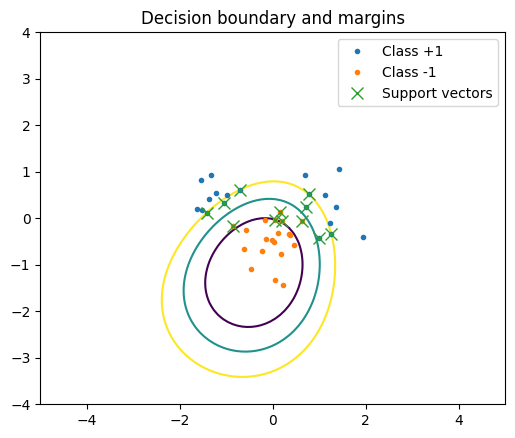

RBF σ=2.0: train_acc=1.000, test_acc=0.975, SVs=12


In [53]:
# Same train/test split pattern; a touch noisier to make the trend obvious
classA, classB, X, t = make_toy_data(seed=20, sigma=0.35,
                                     A1_center=(-1.2,0.5), A2_center=(1.2,0.5), B_center=(0.0,-0.4))
_, _, X_te, t_te = make_toy_data(seed=1200, sigma=0.35,
                                 A1_center=(-1.2,0.5), A2_center=(1.2,0.5), B_center=(0.0,-0.4))

for sigma in [0.15, 0.25, 0.4, 0.8, 2.0]:
    model = DualSVM(Kernels.rbf, C=10.0, kernel_params={'sigma': sigma})
    model.fit(X, t)
    plot_decision_boundary(model, classA, classB)
    train_acc = (model.predict(X) == t).mean()
    test_acc  = (model.predict(X_te) == t_te).mean()
    print(f"RBF σ={sigma}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}, SVs={len(model.alpha)}")
